In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy.stats

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

In [3]:
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                               'age_start': 40,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-10-30 14:04:58.355 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v3-20231019/alabama.hdf.
2023-10-30 14:04:58.356 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2023-10-30 14:04:58.357 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.


In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,alive,sex,entrance_time,age,location,exit_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_multiplier,lifestyle_adherence,sbp_medication_adherence,outreach,sbp_multiplier,ldlc_medication_adherence,ldlc_medication,last_fpg_test_date,visit_type,scheduled_date
0,True,alive,Female,2020-12-04,62.325405,Alabama,NaT,not_dead,0.0,,...,1.3620,False,cat3,cat2,1.00,cat3,medium_intensity,NaT,none,NaT
1,True,alive,Male,2020-12-04,56.583394,Alabama,NaT,not_dead,0.0,,...,1.5125,False,cat3,cat2,1.00,cat3,high_intensity,NaT,none,2021-03-21 23:06:47.554560
2,True,alive,Female,2020-12-04,63.072592,Alabama,NaT,not_dead,0.0,,...,1.0000,True,cat3,cat2,1.00,cat3,no_treatment,NaT,none,NaT
3,True,alive,Male,2020-12-04,50.472918,Alabama,NaT,not_dead,0.0,,...,1.0000,True,cat3,cat2,1.12,cat1,low_intensity,NaT,none,NaT
4,True,alive,Female,2020-12-04,49.552787,Alabama,NaT,not_dead,0.0,,...,1.3620,True,cat2,cat2,1.00,cat3,medium_intensity,NaT,none,NaT


In [5]:
#pop0.columns

In [6]:
#sim.list_values()

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                  ], axis=1)
data1.head()

,tracked,age,alive,entrance_time,sex,location,exit_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,lifestyle,lifestyle_adherence,ldlc_multiplier,sbp_medication_adherence,sbp_therapeutic_inertia_constant_component,visit_type,scheduled_date,last_fpg_test_date,high_sbp,high_sbp_raw
0,True,62.325405,alive,2020-12-04,Female,Alabama,NaT,not_dead,0.0,,...,NaT,False,1.3620,cat3,-0.050506,none,NaT,NaT,147.192049,147.192049
1,True,56.583394,alive,2020-12-04,Male,Alabama,NaT,not_dead,0.0,,...,NaT,False,1.5125,cat3,0.901321,none,2021-03-21 23:06:47.554560,NaT,145.689753,145.689753
2,True,63.072592,alive,2020-12-04,Female,Alabama,NaT,not_dead,0.0,,...,NaT,True,1.0000,cat3,-0.448101,none,NaT,NaT,94.942811,94.942811
3,True,50.472918,alive,2020-12-04,Male,Alabama,NaT,not_dead,0.0,,...,NaT,True,1.0000,cat3,0.133548,none,NaT,NaT,148.753688,165.153688
4,True,49.552787,alive,2020-12-04,Female,Alabama,NaT,not_dead,0.0,,...,NaT,True,1.3620,cat2,-0.216679,none,NaT,NaT,139.227528,139.227528


In [8]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
#data1.loc[data1.sbp_medication != 'no_treatment']

## Running time forward 

In [13]:
## This is the function that reset people on meds back to no treatment. 
## I would expect that this is where you will make edits 

def reset_sbp_medication(step):
##Call the component with treatment 
    treatment = sim.get_component('treatment')

##Get a population view 
    data = treatment.population_view.get(pop_t.index)
    new_med_rows = (data['sbp_medication'] != 'no_treatment') & (global_medication_start < 0)
    global_medication_start[new_med_rows] = step
    
##Actual edit the data 
##More specifically this is where we will make edits to have the first year reset 
    filtered_data = data[(data['sbp_medication'] != 'no_treatment') & (global_medication_start == step)]
    num_rows = int(len(filtered_data) * 0.3)
    indices_to_change = np.random.choice(filtered_data.index, num_rows, replace=False)
    data.loc[indices_to_change, 'sbp_medication'] = 'no_treatment'
    
##Update the data in the population view with the new dataframe that was edited 
    treatment.population_view.update(data)
    return 

In [ ]:
reset_sbp_medication(2)

In [5]:
## I would reset this to 1 time step or 5 time steps to test it 

sim_data = pd.DataFrame()
for step in list(range(0,2)):
    sim.step()
    pop_t = sim.get_population()
    #reset_sbp_medication(step) 
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                       ],axis=1)
    data_t['step'] = step
    data_t_small = data_t[['sex','age','alive','high_sbp','high_sbp_raw','sbp_medication','step']]
    print(step)
    sim_data = pd.concat([sim_data, data_t_small])

0
1


In [15]:
## Save the data - I find this helpful so that if things happen overnight (internet outage, jupyter crash) I still have a copy 

sim_data.to_csv('/ihme/homes/lutzes/med_data_250steps_10_27_23.csv')

# Read in Data and Analysis 

In [3]:
data = pd.read_csv('/ihme/homes/lutzes/med_data_250steps_10_27_23.csv')

In [4]:
data1 = data.loc[(data.age > 25) & (data.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data1['need_meds'] = np.where(data1.high_sbp_raw > 130, 1, 0)

In [5]:
data_need_med = data1.loc[data1.need_meds == 1]
data_need_med.head()

,Unnamed: 0,sex,age,alive,high_sbp,high_sbp_raw,sbp_medication,step,age_start,need_meds
0,0,Female,62.632044,alive,147.192049,147.192049,no_treatment,0,60.0,1
1,1,Male,56.890033,alive,145.689753,145.689753,no_treatment,0,55.0,1
3,3,Male,50.779557,alive,148.753688,165.153688,two_drug_half_dose_efficacy,0,50.0,1
4,4,Female,49.859426,alive,139.227528,139.227528,no_treatment,0,45.0,1
5,5,Male,43.836441,alive,135.545603,135.545603,no_treatment,0,40.0,1


In [6]:
grouped = data_need_med.groupby(['sex','age_start','step','sbp_medication']).size()
errors = pd.DataFrame(grouped).reset_index()
errors['error'] = np.sqrt(errors[0])
#errors
percentages = grouped / data_need_med.groupby(['sex','age_start','step']).size() * 100
percentages= pd.DataFrame(percentages)
percentages = percentages.reset_index()
percentages = percentages.merge(errors[['sex','age_start','step','sbp_medication','error']], on = ['sex','age_start','step','sbp_medication'])
percentages['final_error'] = percentages[0].std() / percentages['error']
percentages

,sex,age_start,step,sbp_medication,0,error,final_error
0,Female,40.0,0,no_treatment,49.668874,8.660254,2.234954
1,Female,40.0,0,one_drug_half_dose_efficacy,30.463576,6.782330,2.853779
2,Female,40.0,0,one_drug_std_dose_efficacy,1.986755,1.732051,11.174771
3,Female,40.0,0,two_drug_half_dose_efficacy,16.556291,5.000000,3.871054
4,Female,40.0,0,two_drug_std_dose_efficacy,1.324503,1.414214,13.686243
...,...,...,...,...,...,...,...
34738,Male,120.0,9,no_treatment,100.000000,1.000000,19.355270
34739,Male,120.0,10,no_treatment,100.000000,1.000000,19.355270
34740,Male,120.0,11,no_treatment,100.000000,1.000000,19.355270
34741,Male,120.0,12,no_treatment,100.000000,1.000000,19.355270


/tmp/ipykernel_3331331/1421583417.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


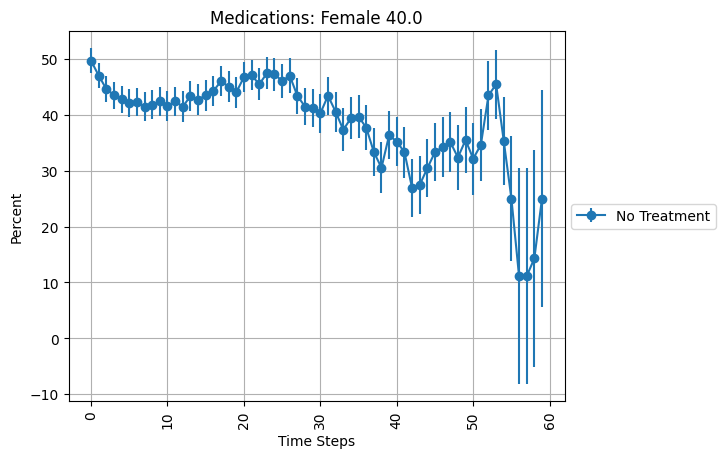

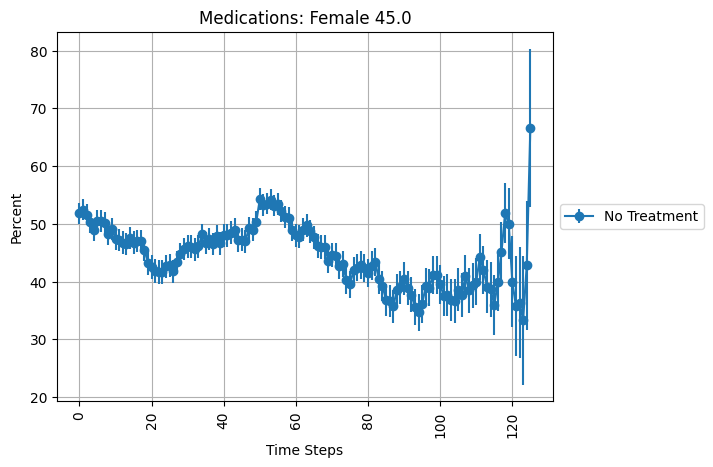

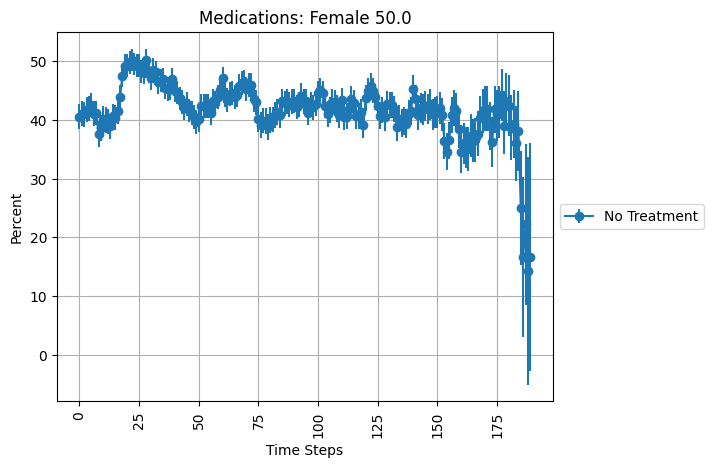

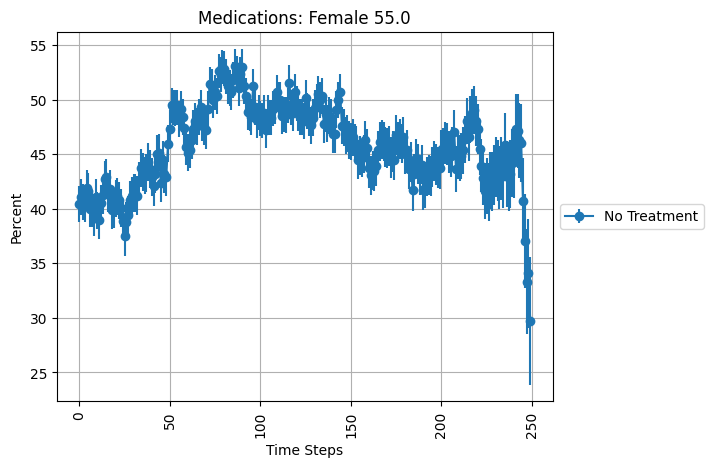

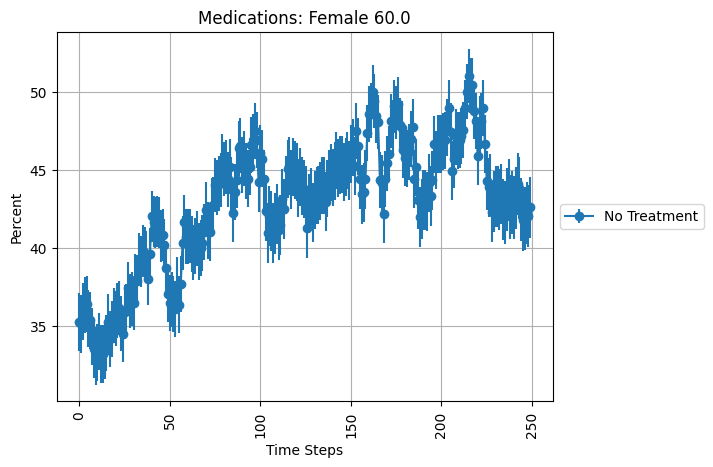

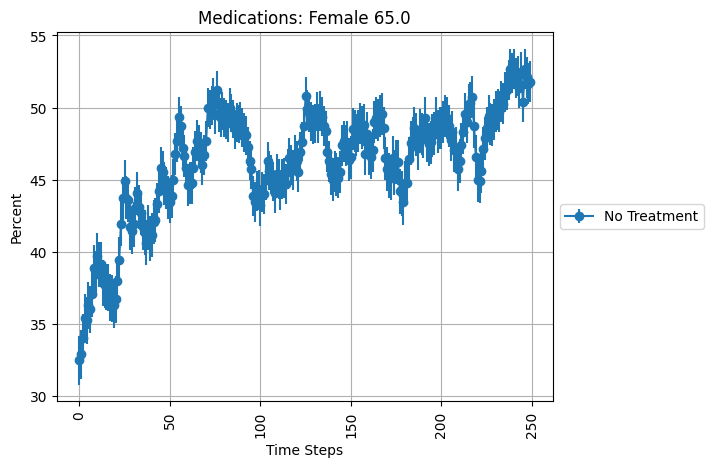

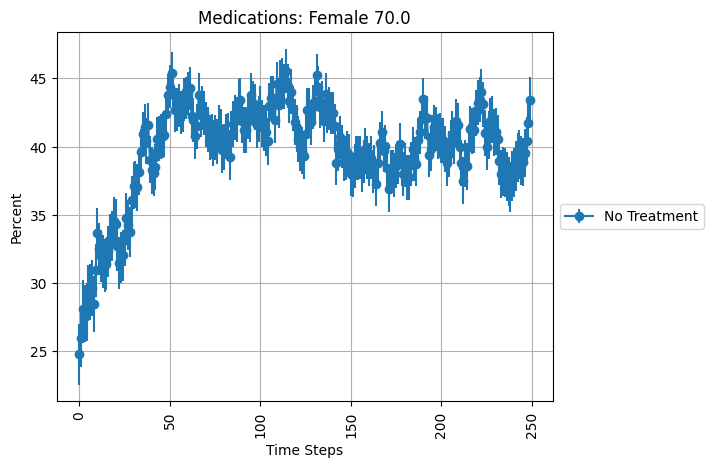

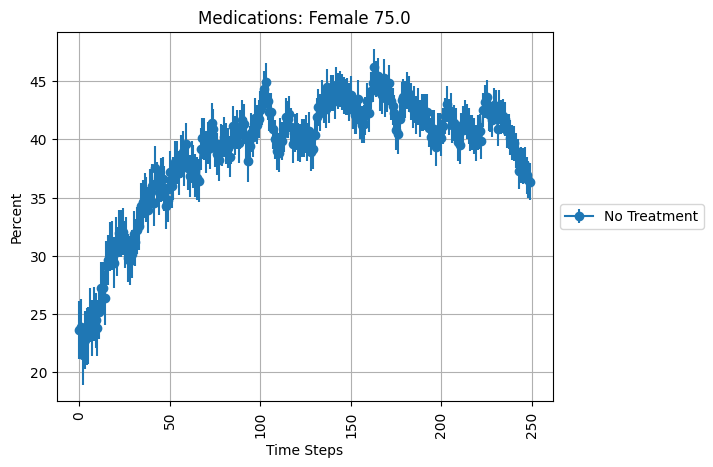

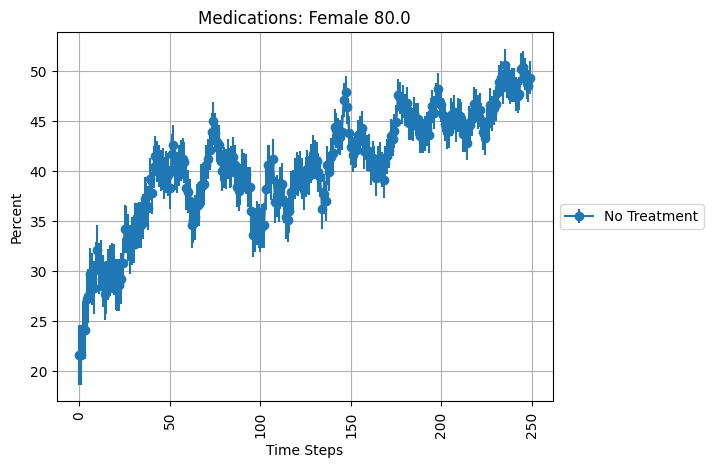

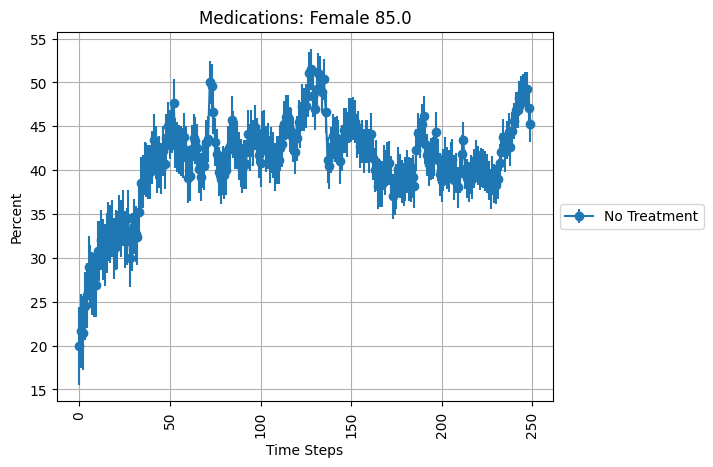

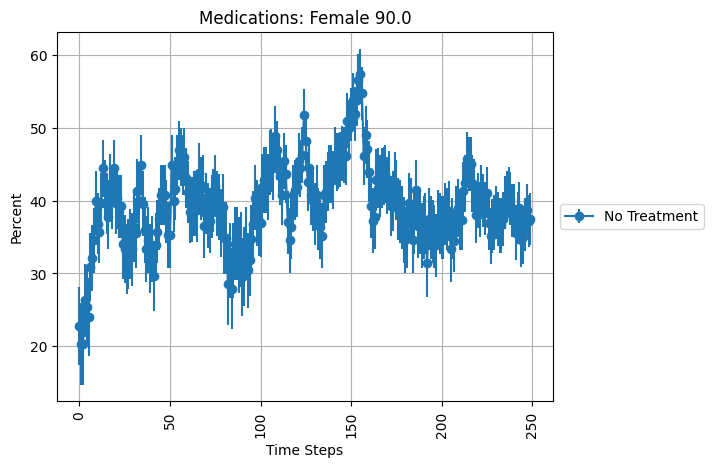

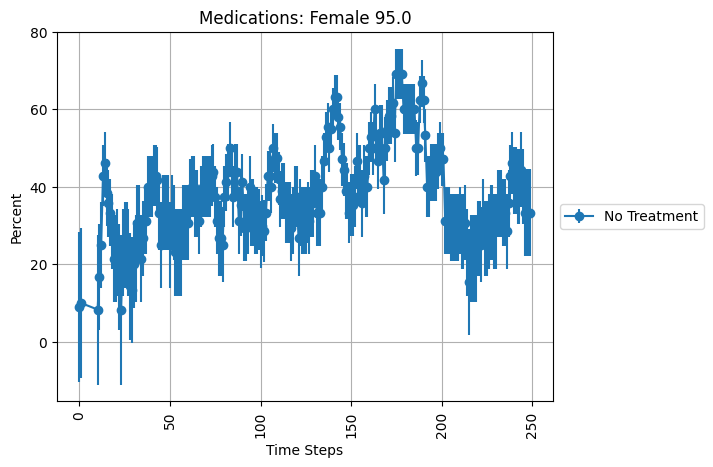

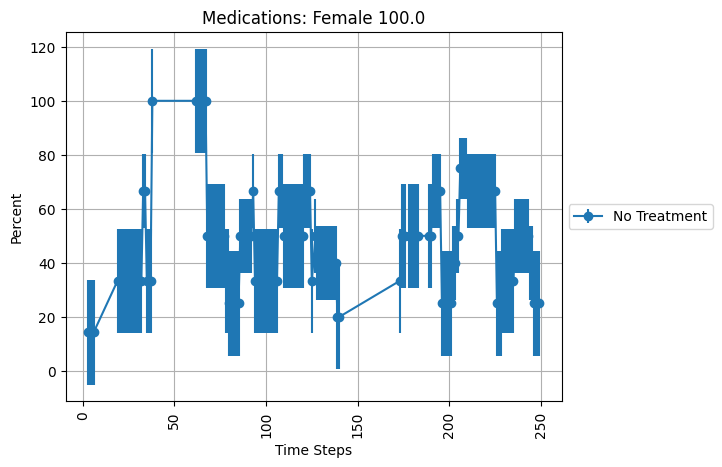

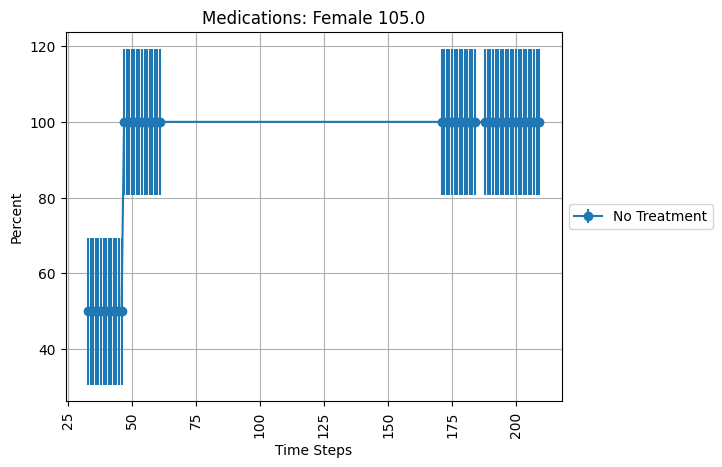

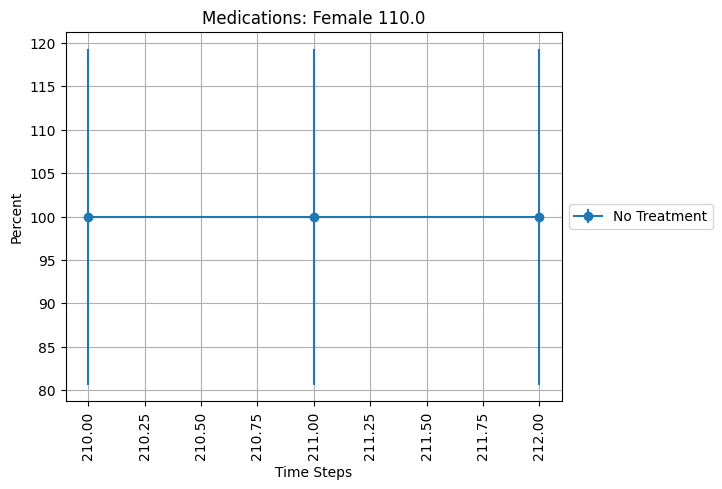

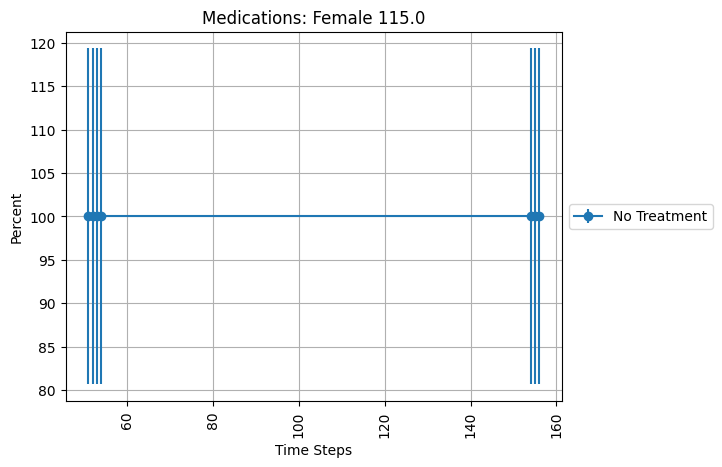

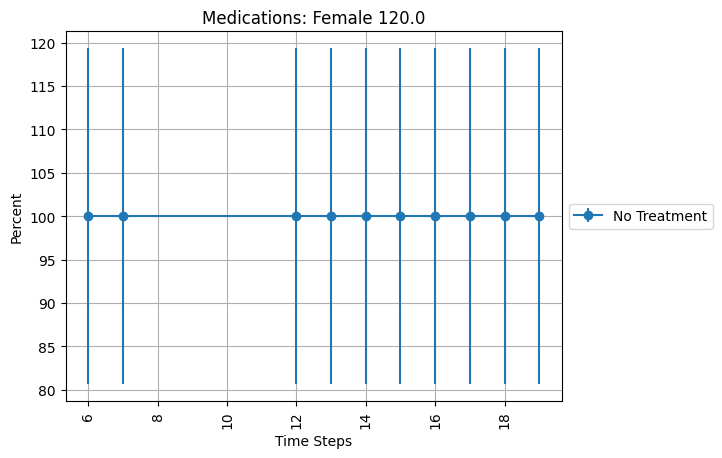

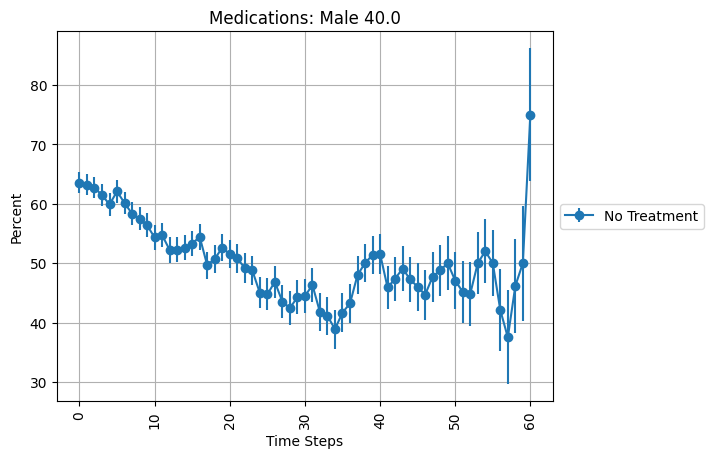

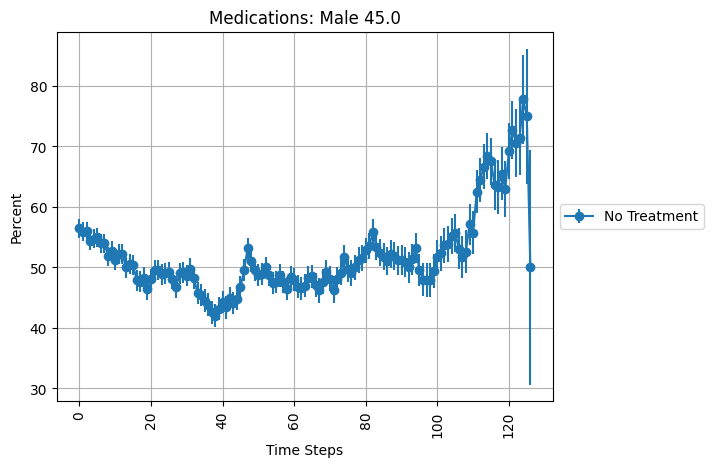

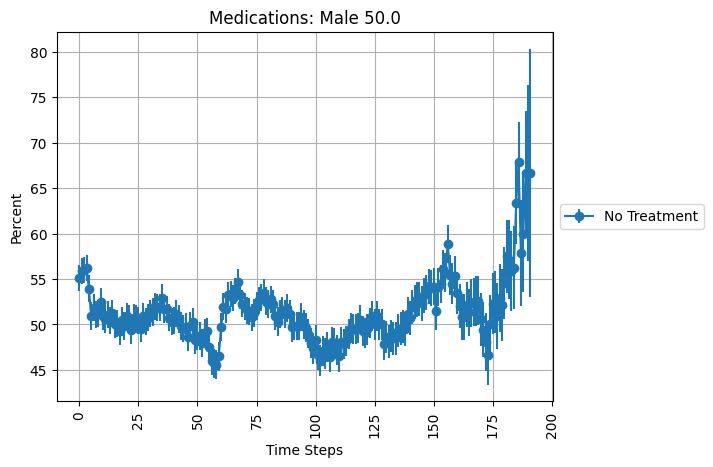

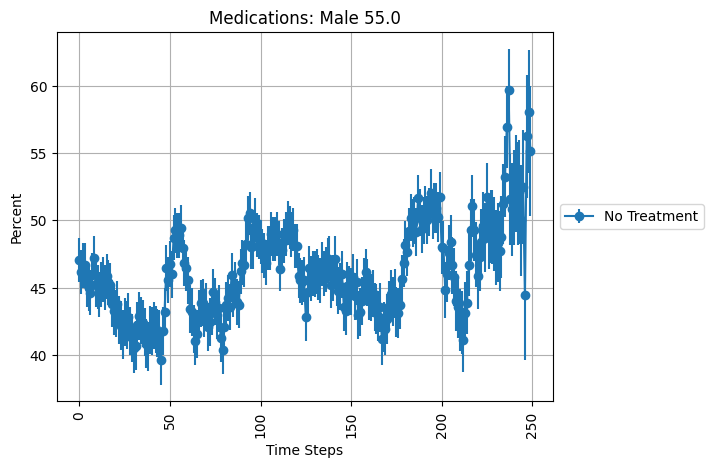

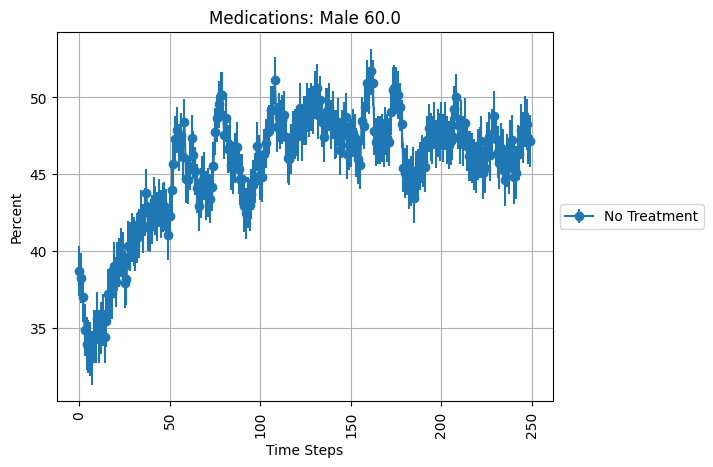

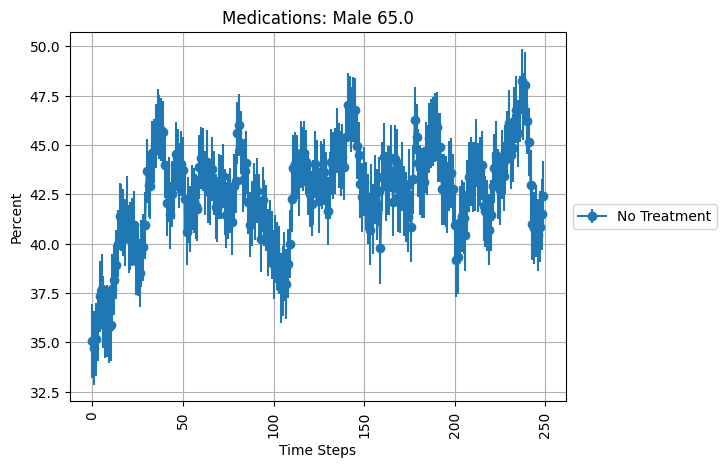

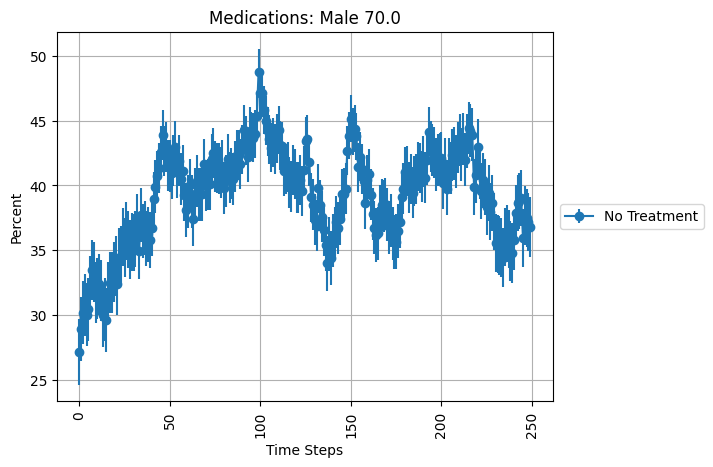

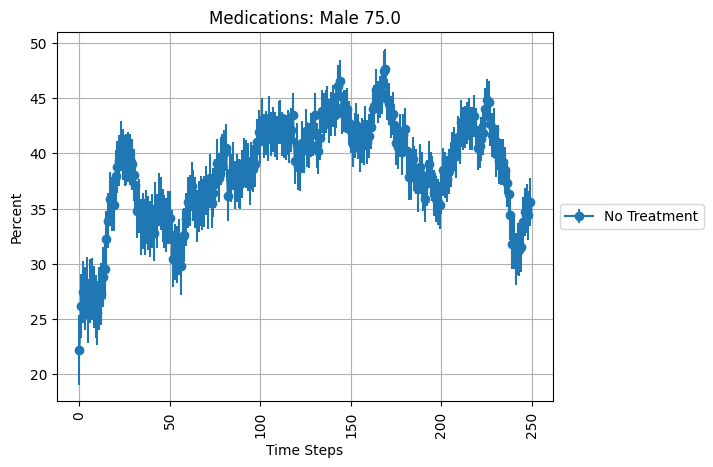

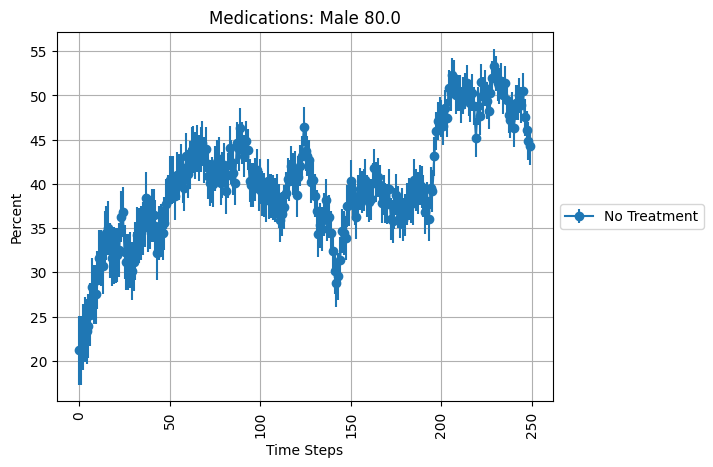

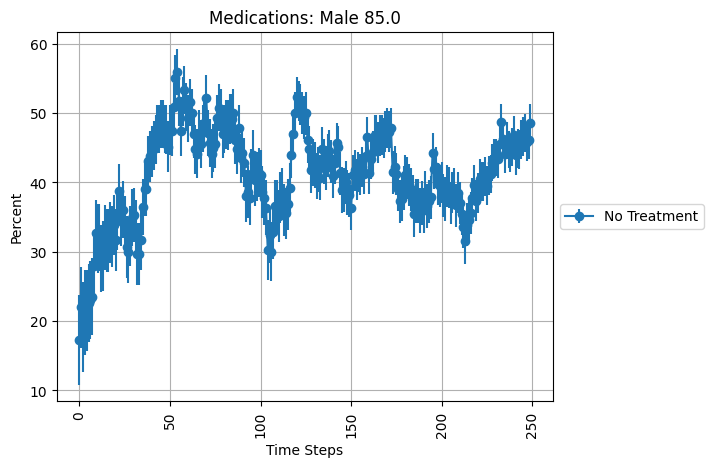

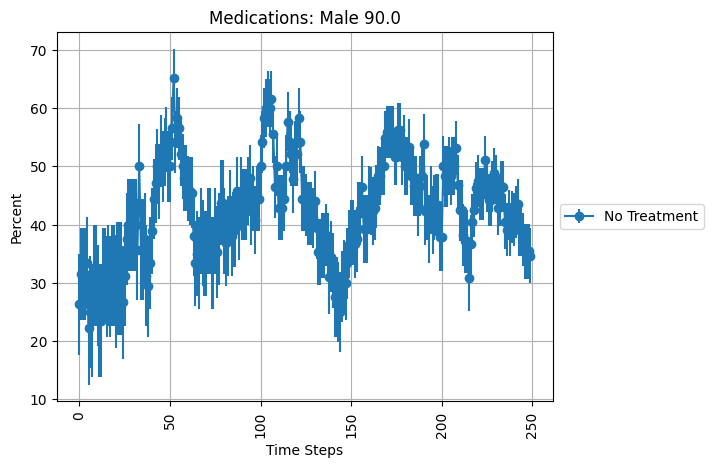

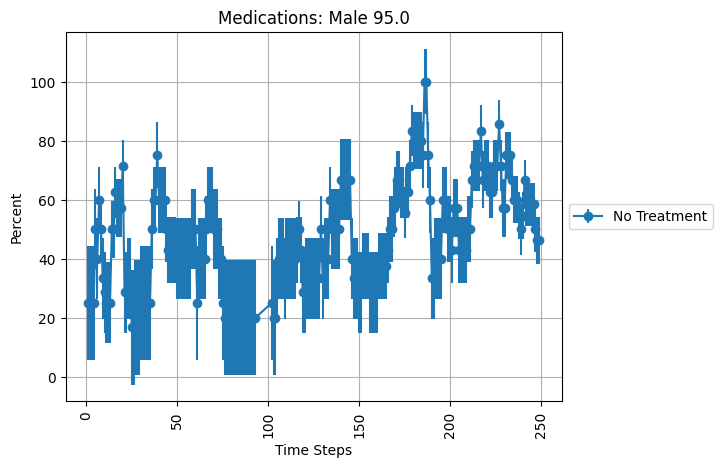

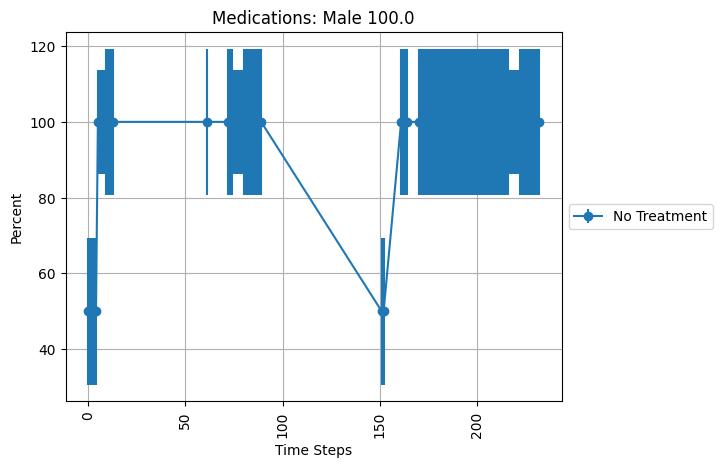

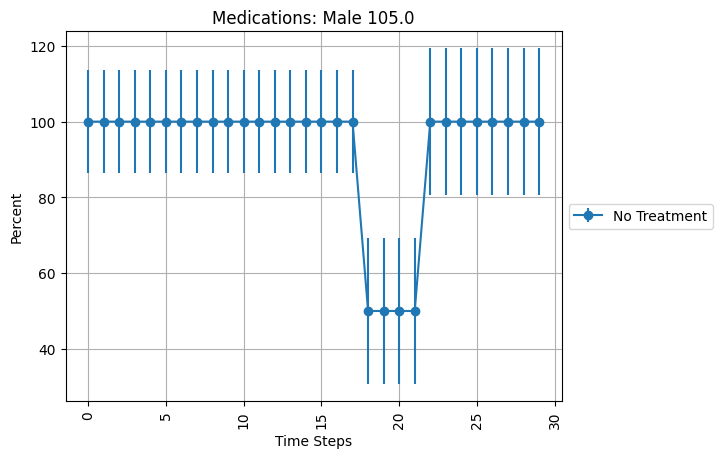

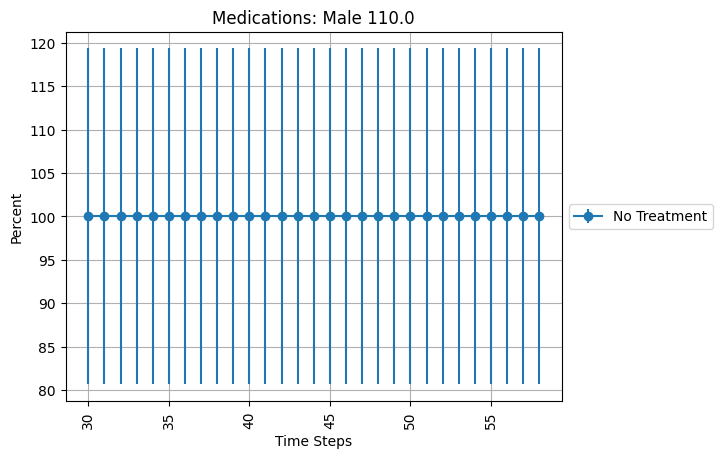

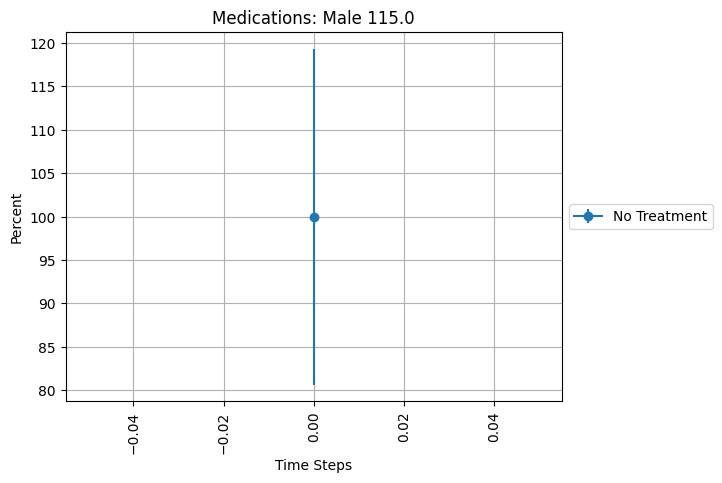

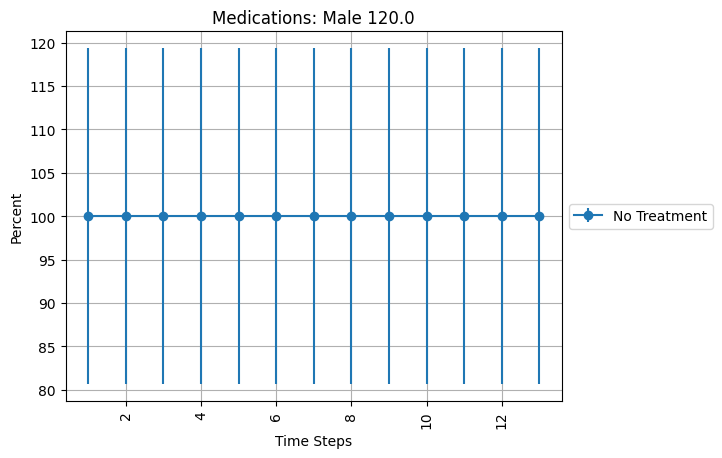

In [7]:
for sex in percentages.sex.unique():
    for age in percentages.age_start.unique(): 
        plt.figure() 
        no_trt = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='no_treatment')]
        plt.errorbar(no_trt['step'], no_trt[0], yerr=no_trt['final_error'], marker='o')
        #one_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_half_dose_efficacy')]
        #plt.plot(one_half['step'], one_half[0], marker='o')
        #one_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_std_dose_efficacy')]
        #plt.plot(one_std['step'], one_std[0], marker='o')
        #two_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_half_dose_efficacy')]
        #plt.plot(two_half['step'], two_half[0], marker='o')
        #two_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_std_dose_efficacy')]
        #plt.plot(two_std['step'], two_std[0], marker='o')
        #three_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_half_dose_efficacy')]
        #plt.plot(three_half['step'], three_half[0], marker='o')
        #three_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_std_dose_efficacy')]
        #plt.plot(three_std['step'], three_std[0], marker='o')
        plt.title(f'Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.ylabel('Percent')
        plt.xlabel('Time Steps')
        plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()